In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
# from category_encoders import MEstimateEncoder

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'category_encoders'

EDA & Pre-processing of dataset

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

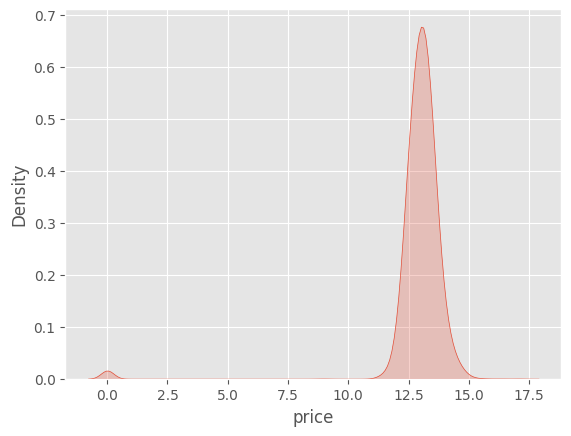

In [ ]:
# let's check the distribution of our target column
sns.kdeplot(df['price'].apply(np.log1p), fill=True)
plt.show()

In [ ]:
# Function to create Z-Score
def make_mi_score(x,y):
    x = x.copy()
    for colname in x.select_dtypes(['object','category']):
        x[colname], _ = x[colname].factorize()

    discrete_features = [pd.api.types.is_integer_dtype(t) for t in x.dtypes]
    mi_score = mutual_info_regression(x, y, discrete_features=discrete_features, random_state=42)
    mi_score = pd.Series(mi_score, name='Mutual Information Score', index=x.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

In [ ]:
X = df.drop(columns=['price'])
y = df[['price']]

mi_score = make_mi_score(X, y)
mi_score

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Mutual Information Score
street,1.187259
statezip,0.453802
city,0.315389
sqft_living,0.298434
sqft_above,0.200396
bathrooms,0.184815
sqft_lot,0.145104
bedrooms,0.080524
yr_built,0.075527
floors,0.053934


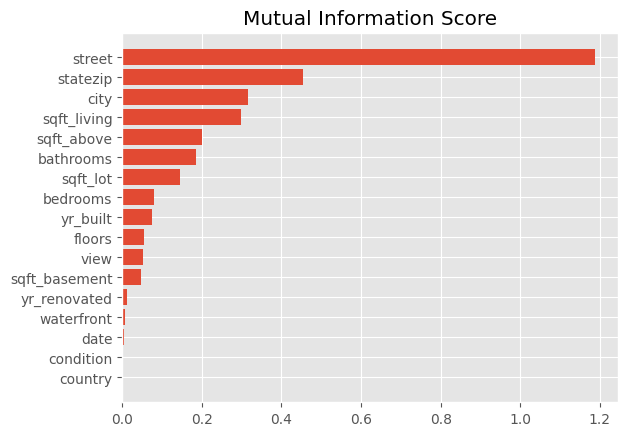

In [ ]:
def plot_mi_score(score):
    score = score.sort_values(ascending = True)
    width = np.arange(len(score))
    ticks = list(score.index)
    plt.barh(width,score)
    plt.yticks(width,ticks)
    plt.title('Mutual Information Score')

plot_mi_score(mi_score)

In [ ]:
# Refining the dataset based on mutual information score
df = df[['street','statezip','city','sqft_living','sqft_above','bathrooms','yr_built','sqft_lot','bedrooms']]

In [ ]:
df

,street,statezip,city,sqft_living,sqft_above,bathrooms,yr_built,sqft_lot,bedrooms
0,18810 Densmore Ave N,WA 98133,Shoreline,1340,1340,1.50,1955,7912,3.0
1,709 W Blaine St,WA 98119,Seattle,3650,3370,2.50,1921,9050,5.0
2,26206-26214 143rd Ave SE,WA 98042,Kent,1930,1930,2.00,1966,11947,3.0
3,857 170th Pl NE,WA 98008,Bellevue,2000,1000,2.25,1963,8030,3.0
4,9105 170th Ave NE,WA 98052,Redmond,1940,1140,2.50,1976,10500,4.0
...,...,...,...,...,...,...,...,...,...
4595,501 N 143rd St,WA 98133,Seattle,1510,1510,1.75,1954,6360,3.0
4596,14855 SE 10th Pl,WA 98007,Bellevue,1460,1460,2.50,1983,7573,3.0
4597,759 Ilwaco Pl NE,WA 98059,Renton,3010,3010,2.50,2009,7014,3.0
4598,5148 S Creston St,WA 98178,Seattle,2090,1070,2.00,1974,6630,4.0


In [ ]:
df = df.join(y)

Removing Outliers with Z-score
While calculating the z-score we rescale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be trated as the outliers.

In most of the cases a threshold of 3 or -3 is used. If the Z-score value is greater than or less than 3 or -3 respectively, that data points will be defines as outliers.

In [ ]:
z = np.abs(stats.zscore(df[['sqft_living','sqft_above','bathrooms','yr_built','sqft_lot','bedrooms']]))
print(z)

[[0.82997105 0.56522378 0.84320364 0.53101376 0.19343402 0.44112227]
 [1.56852826 1.78955903 0.43280154 1.67469295 0.16171766 1.75970468]
 [0.21736733 0.11917123 0.20520105 0.1609999  0.0809775  0.44112227]
 ...
 [0.90400897 1.37196208 0.43280154 1.2854179  0.21846151 0.44112227]
 [0.05123751 0.87842149 0.20520105 0.10810108 0.2291637  0.6592912 ]
 [0.67422434 0.39122505 0.43280154 0.64630305 0.18813867 0.44112227]]


In [ ]:
threshold = 3
print(np.where(z > 3))

(array([  56,  107,  122,  122,  122,  122,  122,  217,  227,  233,  240,
        241,  252,  252,  252,  254,  272,  291,  291,  375,  418,  418,
        452,  461,  462,  462,  462,  462,  471,  479,  484,  495,  548,
        575,  581,  581,  634,  634,  634,  675,  679,  743,  747,  779,
        798,  839,  847,  878,  879,  999, 1017, 1031, 1078, 1089, 1103,
       1128, 1130, 1132, 1132, 1182, 1182, 1209, 1209, 1209, 1261, 1265,
       1272, 1275, 1275, 1301, 1302, 1302, 1360, 1390, 1406, 1408, 1411,
       1417, 1417, 1424, 1455, 1479, 1500, 1539, 1567, 1567, 1571, 1602,
       1637, 1644, 1722, 1762, 1786, 1944, 1952, 1952, 1962, 1962, 2005,
       2005, 2152, 2155, 2157, 2199, 2226, 2279, 2286, 2286, 2300, 2316,
       2328, 2328, 2328, 2365, 2401, 2480, 2551, 2588, 2654, 2654, 2654,
       2717, 2725, 2731, 2731, 2731, 2731, 2761, 2761, 2846, 2846, 2855,
       2872, 2889, 2917, 2967, 2967, 2967, 2968, 2980, 2980, 3004, 3004,
       3004, 3004, 3046, 3056, 3099, 3117, 3122, 3

In [ ]:
df = df[(z < 3).all(axis=1)]

In [ ]:
df.shape

(4435, 10)

In [ ]:
df.head()

,street,statezip,city,sqft_living,sqft_above,bathrooms,yr_built,sqft_lot,bedrooms,price
0,18810 Densmore Ave N,WA 98133,Shoreline,1340,1340,1.50,1955,7912,3.0,313000.0
1,709 W Blaine St,WA 98119,Seattle,3650,3370,2.50,1921,9050,5.0,2384000.0
2,26206-26214 143rd Ave SE,WA 98042,Kent,1930,1930,2.00,1966,11947,3.0,342000.0
3,857 170th Pl NE,WA 98008,Bellevue,2000,1000,2.25,1963,8030,3.0,420000.0
4,9105 170th Ave NE,WA 98052,Redmond,1940,1140,2.50,1976,10500,4.0,550000.0


Training and Testing the dataset

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

Target Encoding
We saw in our mutual information score that street, city and zipcodes do affect the pricing of house. And which makes sense from a buyer's perspective as well. Houses belong to an urban area have higher prices compare to the areas which are far from city.

So to drive this point home, we should not neglect that features. What we can do is, with the help of target encoding we will encode these fetures.

In [ ]:
encoder = MEstimateEncoder(cols=['street','statezip','city'], m=0.5)

X = encoder.fit_transform(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [ ]:
!pip install --upgrade category_encoders
from category_encoders import MEstimateEncoder
encoder = MEstimateEncoder(cols=['street','statezip','city'], m=0.5)

X = encoder.fit_transform(X, y)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 5.0 MB/s eta 0:00:00


ML Algorithm

In [ ]:

from scipy import stats

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
# from category_encoders import MEstimateEncoder

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [ ]:
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
model.score(X_train, y_train)

0.9867693469079718

In [ ]:
model.score(X_test, y_test)

0.9864328751764341

In [ ]:
from sklearn.model_selection import cross_val_score

cvs = cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1)
print('Accuracy: {:.2f} %'.format(cvs.mean() * 100))

Accuracy: 96.52 %


In [ ]:
y_pred = model.predict(X_test)

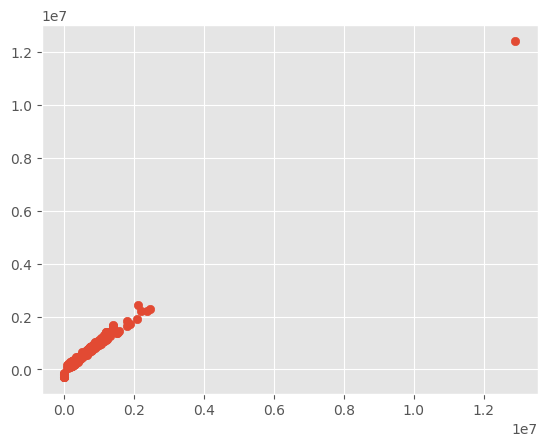

In [ ]:
plt.scatter(y_test,y_pred)
plt.show()